In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pylab import rcParams
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score, auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn import tree 
import xgboost as xgb_package
import shap

C:\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#to visualise
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [3]:
#reading files
all_pairs = pd.read_csv("all_pairs.csv", sep= ";")
all_pairs = all_pairs.dropna(how='all')              # drops fully empty rows
all_pairs = all_pairs.dropna(axis=1, how='all')      # drops fully empty columns

In [4]:
all_pairs = all_pairs[(all_pairs['neighbour in IUPred'] == 1)]
all_pairs.shape

(4546, 84)

In [5]:
npos = len(all_pairs[all_pairs['neighbour biomarker for target?'] == 1])
print(npos)

332


In [6]:
# Defining positive control
training_pos =all_pairs[all_pairs['neighbour biomarker for target?'] == 1]

In [7]:
# Negative control = not biomarker in CIViCmine
training_neg = all_pairs[
    (all_pairs['neighbour biomarker for target?'] == 0) &
    (all_pairs['prognostic'] == 0) &
    (all_pairs['predisposing'] == 0) &
    (all_pairs['diagnostic'] == 0) &
    (all_pairs['predictive'] == 0)]
training_neg.shape

(544, 84)

In [8]:
training = pd.concat([training_pos, training_neg], ignore_index=True)

In [9]:
#titles list
titles = list(training.head())
CSN = [s for s in titles if "CSN" in s]
SIGNOR = [s for s in titles if "SIGNOR" in s]
ReactomeFI = [s for s in titles if "ReactomeFI" in s]
print(CSN, SIGNOR, ReactomeFI)

['neighbour in CSN', 'target in CSN', 'both in CSN', 'in triangle - CSN', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'DisProt neighbour third partner - CSN', 'target third partner - CSN', 'neighbour bridgeness - CSN', 'neighbour betweenness - CSN', 'target bridgeness - CSN', 'target betweenness - CSN'] ['neighbour in SIGNOR', 'target in SIGNOR', 'both in SIGNOR', 'in  triangle - SIGNOR', 'no. of triangles - SIGNOR', 'no. of in  cycle - SIGNOR', 'no. of in  unbalanced triangle - SIGNOR', 'neighbour – target inhibition - SIGNOR', 'target – neighbour stimulation - SIGNOR', 'neighbour – target stimulation - SIGNOR', 'target – neighbour inhibition - SIGNOR', 'DisProt neighbour third partner - SIGNOR', 'target third partner - SIGNOR', 'neighbour bridgeness - SIGNOR', 'neighbour betweenness 

In [10]:
#what to drop - second option
to_drop = ["neighbour UniProt", "neighbour name - universal", "target UniProt", "target name - universal", 
           "prognostic", "predisposing", "diagnostic", "predictive",
           "neighbour DisProt IDP", "neighbour DisProt disorder content", "neighbour in AlphaFold", 
           "neighbour AlphaFold average pLLDT", "neighbour AlphaFold disorder %", "target DisProt IDP", 
           "target DisProt disorder content", "target AlphaFold average pLLDT", "target AlphaFold disorder %",
           "neighbour in IUPred"]
only_CSN = to_drop + SIGNOR + ReactomeFI
only_SIGNOR = to_drop + CSN + ReactomeFI 
only_ReactomeFI = to_drop + CSN + SIGNOR

In [11]:
#classifiers - hyperparameters optimalised
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state=42,
                                subsample= 0.75,
                                scale_pos_weight= 0.25,
                                reg_lambda= 0,
                                reg_alpha= 0.5,
                                min_child_weight= 0.5,
                                max_leaves= 11,
                                max_depth= 7,
                                max_delta_step= 1,
                                max_bin= 32,
                                learning_rate= 1,
                                importance_type= 'cover',
                                grow_policy= 'lossguide',
                                gamma= 0.5,
                                criterion= 'log_loss',
                                booster= 'gbtree')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False, #disabled, otherwise gives error with multiple training sets
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0.1,
                             min_samples_split= 4,
                             min_samples_leaf= 5,
                             max_samples= 71,
                             max_leaf_nodes= 29,
                             max_features= 'sqrt',
                             max_depth= 3,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)

In [12]:
#data preparation
def prepare_data_feature_names(training=training, to_drop= to_drop):
    """
    This function prepares the training data for the machine learning.
    Drops the previously selected columns using the to_drop list without renaming the remaining columns.
    Splits the training data to input parameters and labels.
    Lists the column of input parameters.

    Args:
        to_drop: The list of column names which are going to be dropped from the training and unknown dataframe. 
        training: The dataframe of input parameters which are intended to use to the training of the machine learning model.

    Returns:
        X: The input data from the training dataframe.
        y: The labels for the training dataframe.
        feature_names: The list of column names in the X dataframe.

    """
    training_deleted = training.drop(columns= to_drop)
    X = training_deleted.iloc[:,:-1]
    y = training_deleted.iloc[:, -1]
    feature_names = list(X.columns)
    return X, y, feature_names

In [13]:
#teaching - ROC function
def teach_print_train_ROC_SHAP(classifier, X, y):
    """
    This function teaches and tests the selected machine learning models while drawing the ROC curve and confusion matrix.
    Fits StandardScaler on the training data and transforms the training data.
    Makes predictions on the training dataframe.
    Draws the ROC curve.
    Uses SHAP analysis.

    Args:
        X: The input data which will be used for training and testing the model.
        y: The labels for the X dataframe.
        classifier: The choosen classification algorhythm.

        
    Returns:
        classifier_pred_train: Predictions on the training dataset.

    """
    #fitting scale
    scale = StandardScaler()
    scale.fit(X)
    X = scale.transform(X)
        
    #teaching
    classifier.fit(X, y)

    classifier_pred_train = classifier.predict(X)
    
    print(classifier)
    
    #train ROC curve
    ax1 = plt.gca()
    classifier_disp = RocCurveDisplay.from_estimator(classifier, X, y, ax=ax1, alpha=0.8)  
    
    #SHAP
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, feature_names=feature_names)
    
    return classifier_pred_train

[21:24:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='log_loss', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.5, gpu_id=-1,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints='', learning_rate=1, max_bin=32,
              max_cat_to_onehot=4, max_delta_step=1, max_depth=7, max_leaves=11,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
       

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


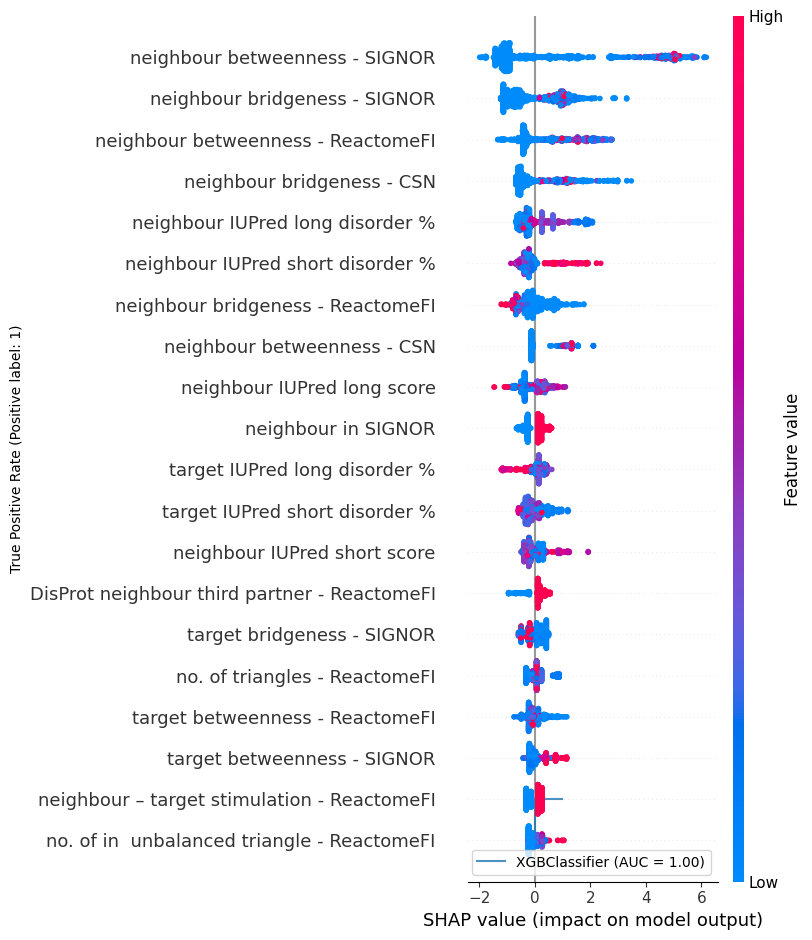

RandomForestClassifier(ccp_alpha=0, class_weight='balanced',
                       criterion='log_loss', max_depth=3, max_leaf_nodes=29,
                       max_samples=71, min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.1, n_estimators=1000,
                       n_jobs=31, random_state=42)


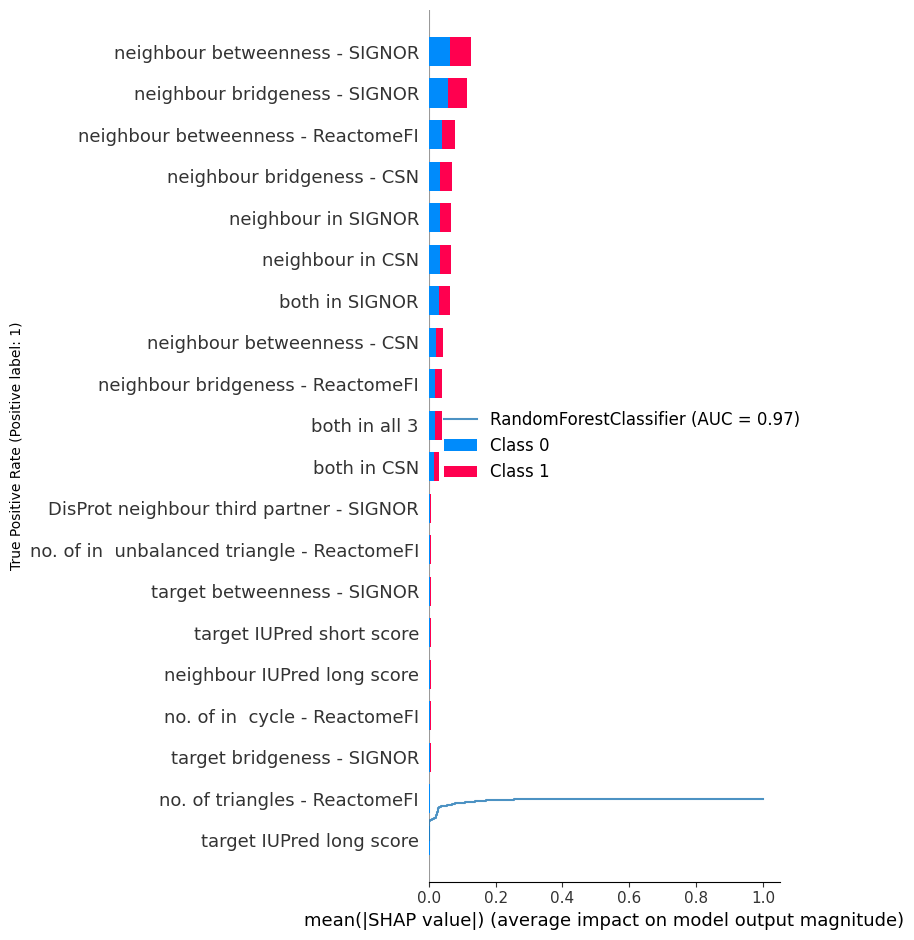

In [14]:
#basic
X, y, feature_names = prepare_data_feature_names()
xgb_pred_train = teach_print_train_ROC_SHAP(xgb, X, y)
rfc_pred_train = teach_print_train_ROC_SHAP(rfc, X, y)

[21:24:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='log_loss', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.5, gpu_id=-1,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints='', learning_rate=1, max_bin=32,
              max_cat_to_onehot=4, max_delta_step=1, max_depth=7, max_leaves=11,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
       

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


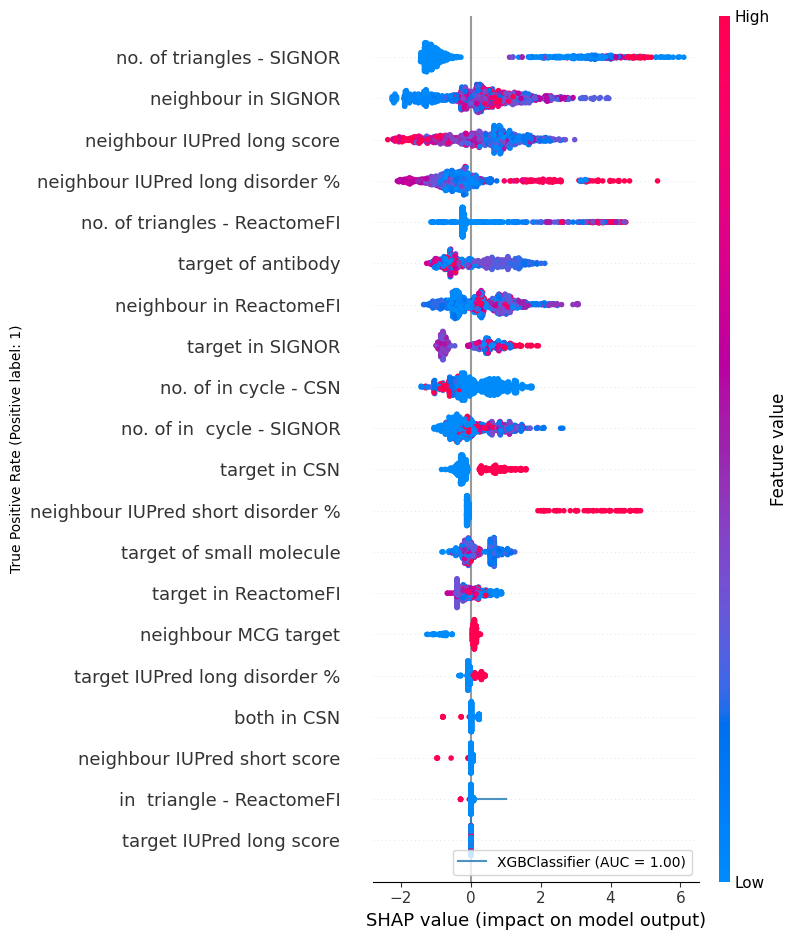

RandomForestClassifier(ccp_alpha=0, class_weight='balanced',
                       criterion='log_loss', max_depth=3, max_leaf_nodes=29,
                       max_samples=71, min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.1, n_estimators=1000,
                       n_jobs=31, random_state=42)


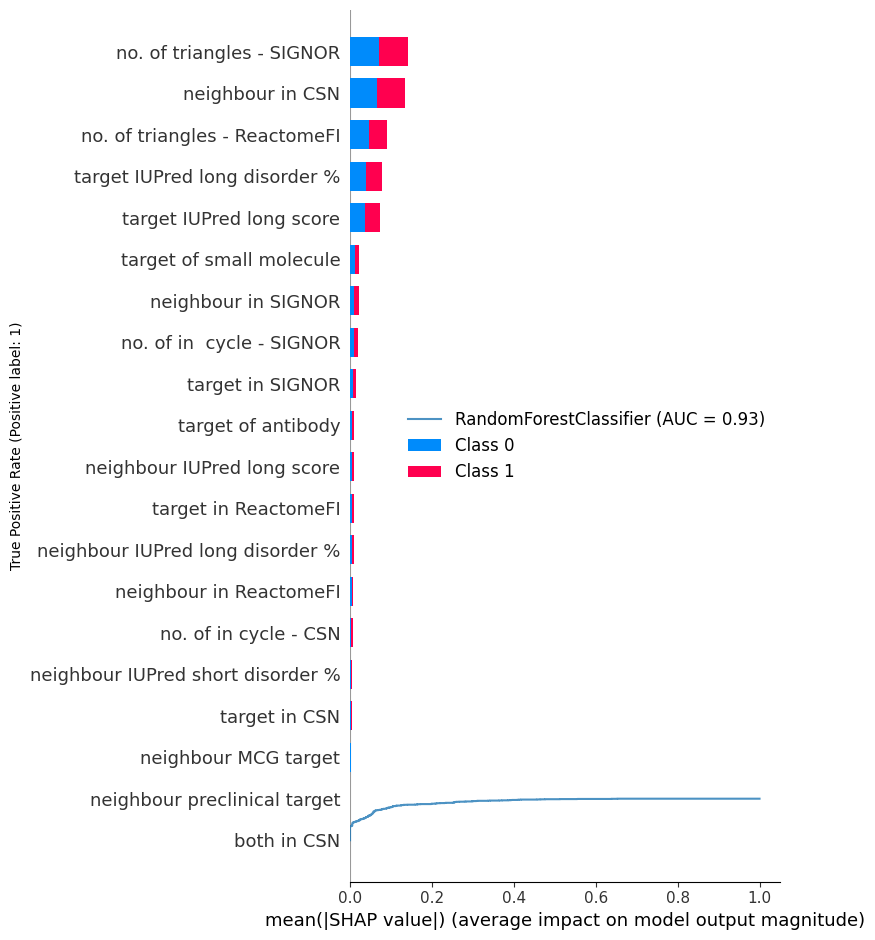

In [15]:
#CSN
X_CSN, y, feature_names_CSN = prepare_data_feature_names(to_drop=only_CSN)
xgb_pred_train = teach_print_train_ROC_SHAP(xgb, X_CSN, y)
rfc_pred_train = teach_print_train_ROC_SHAP(rfc, X_CSN, y)

[21:24:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='log_loss', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.5, gpu_id=-1,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints='', learning_rate=1, max_bin=32,
              max_cat_to_onehot=4, max_delta_step=1, max_depth=7, max_leaves=11,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
       

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


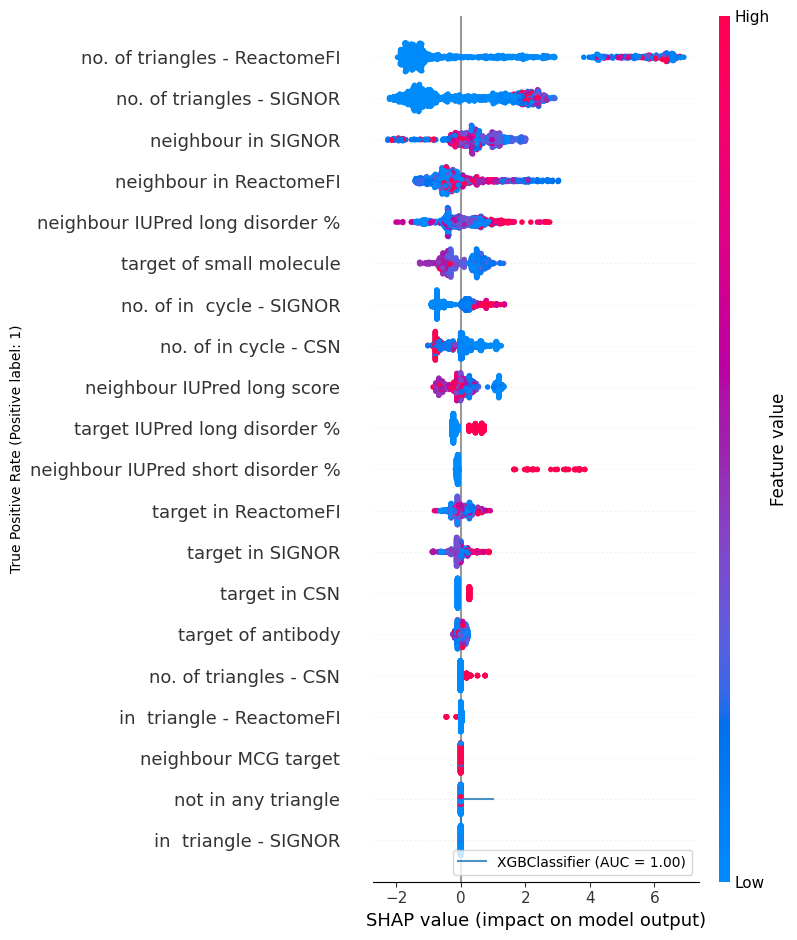

RandomForestClassifier(ccp_alpha=0, class_weight='balanced',
                       criterion='log_loss', max_depth=3, max_leaf_nodes=29,
                       max_samples=71, min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.1, n_estimators=1000,
                       n_jobs=31, random_state=42)


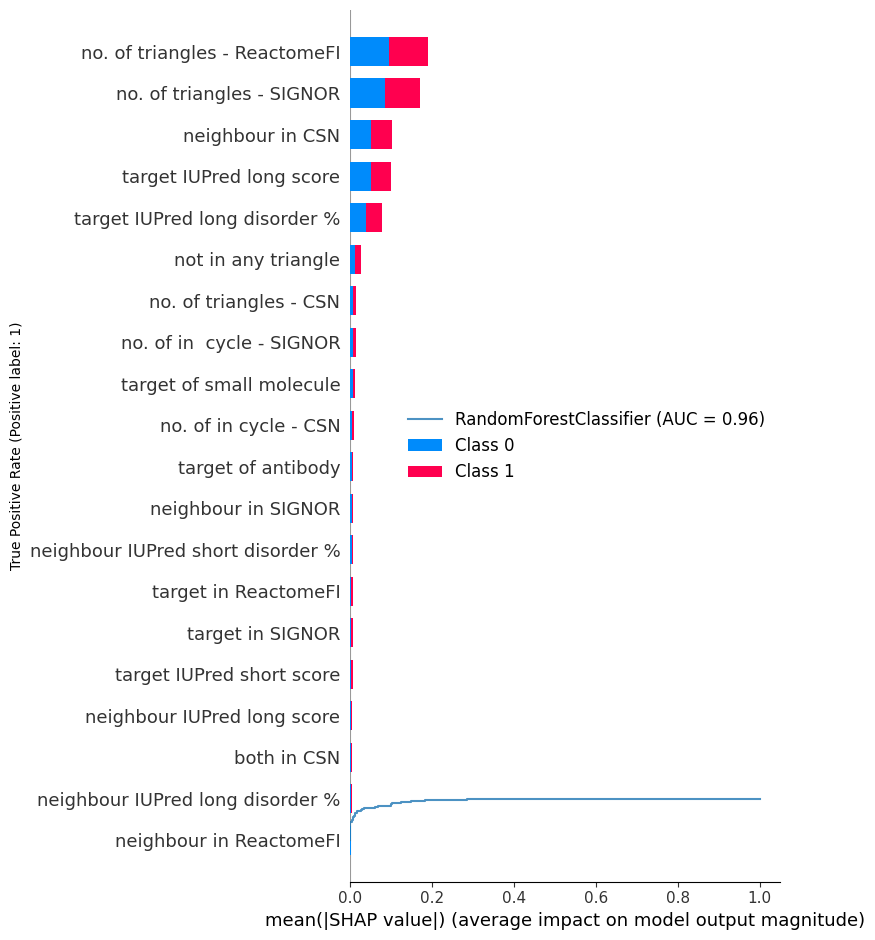

In [16]:
#SIGNOR
X_SIGNOR, y, feature_names_SIGNOR = prepare_data_feature_names(to_drop=only_SIGNOR)
xgb_pred_train = teach_print_train_ROC_SHAP(xgb, X_SIGNOR, y)
rfc_pred_train = teach_print_train_ROC_SHAP(rfc, X_SIGNOR, y)

[21:24:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='log_loss', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.5, gpu_id=-1,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints='', learning_rate=1, max_bin=32,
              max_cat_to_onehot=4, max_delta_step=1, max_depth=7, max_leaves=11,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
       

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


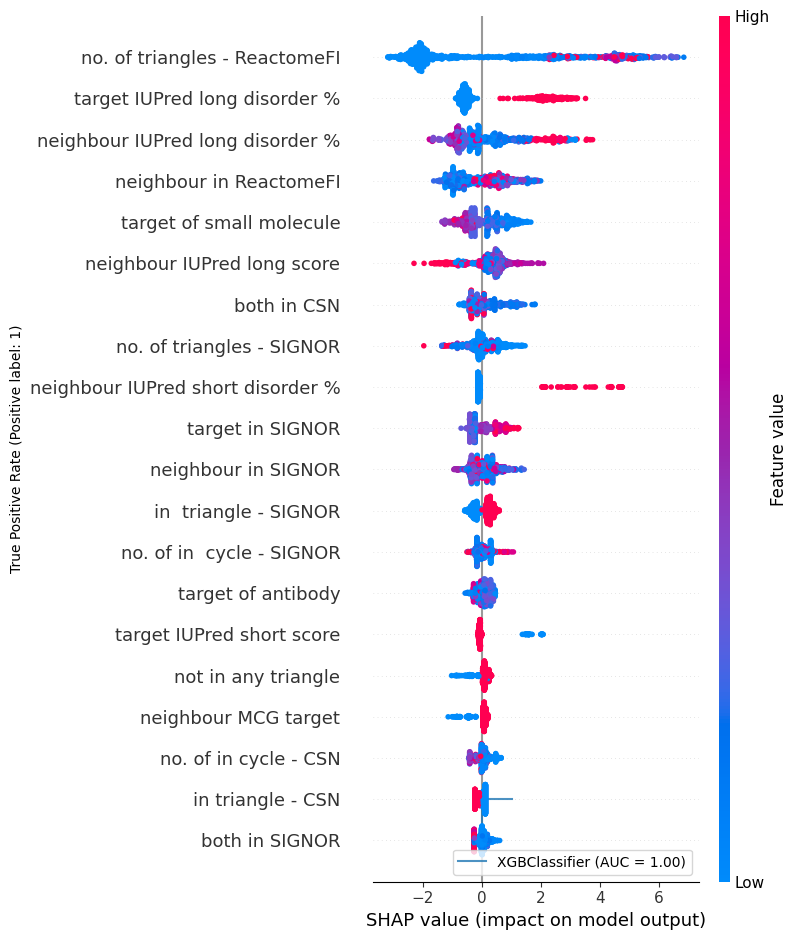

RandomForestClassifier(ccp_alpha=0, class_weight='balanced',
                       criterion='log_loss', max_depth=3, max_leaf_nodes=29,
                       max_samples=71, min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.1, n_estimators=1000,
                       n_jobs=31, random_state=42)


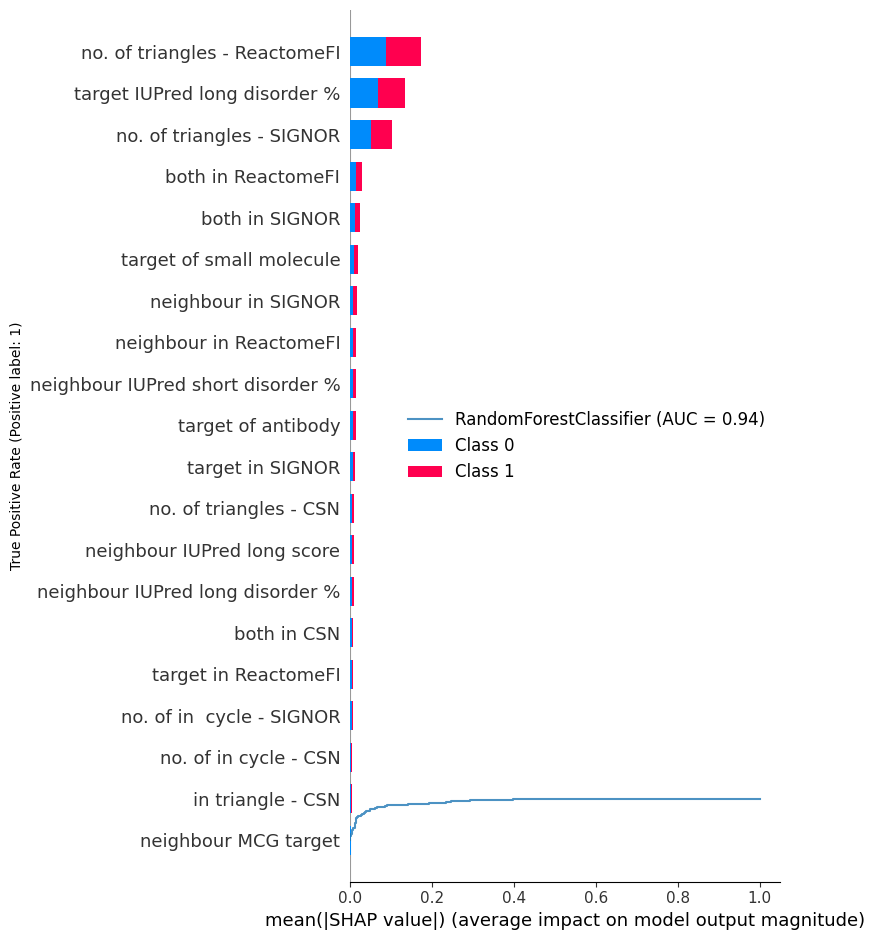

In [17]:
#ReactomeFI
X_ReactomeFI, y, feature_names_ReactomeFI = prepare_data_feature_names(to_drop=only_ReactomeFI)
xgb_pred_train = teach_print_train_ROC_SHAP(xgb, X_ReactomeFI, y)
rfc_pred_train = teach_print_train_ROC_SHAP(rfc, X_ReactomeFI, y)